In [2]:
from PIL import Image
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import unicodedata
import numpy as np
import os
import json
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import math
import random


/home/ant/miniconda3/envs/psl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# # Open an image file
# img = Image.open('images/A.jpg')  # Replace 'path_to_your_image.jpg' with the actual path to your image file

# # Display basic information about the image
# print(f"Image format: {img.format}")
# print(f"Image mode: {img.mode}")
# print(f"Image size: {img.size}")

# # Show the image
# img.show()
# # Display the image
# concatenated_img = np.concatenate((img, img), axis=1)

# plt.imshow(concatenated_img)
# plt.axis('off')  # Turn off axis labels
# # plt.show()
# print()

In [4]:
def replace_polish_characters(label):
    label = label.upper()  # Zamień na wielkie litery
    # label = label.replace('Ą', 'A')
    label = label.replace('Ć', 'C')
    label = label.replace('Ę', 'E')
    label = label.replace('CH', 'H')
    label = label.replace('I', 'J')
    label = label.replace('Ł', 'L')
    label = label.replace('Ń', 'N')
    label = label.replace('Ó', 'O')
    label = label.replace('RZ', 'R')
    label = label.replace('Ś', 'S')
    label = label.replace('Ź', 'Z')
    label = label.replace('Ż', 'Z')
    # Dodaj pozostałe zamiany według potrzeb

    # Usuń diakrytyki z pozostałych znaków
    label = ''.join(c for c in unicodedata.normalize('NFD', label) if unicodedata.category(c) != 'Mn')

    return label

In [5]:
# Function to preprocess the data
def preprocess_data(labels_folder):
    labeled_with_landmarks_count = 0
    labeled_without_landmarks_count = 0
    data_rows = []
    labels = []

    for filename in tqdm(os.listdir(labels_folder)):
        if filename.endswith('.json'):
            with open(os.path.join(labels_folder, filename), 'r', encoding='utf-8') as json_file:
                data = json.load(json_file)
                if 'hand_landmarks' in data:
                    labeled_with_landmarks_count += 1

                    landmarks_data = data['hand_landmarks']
                    row = []

                    for landmark_key in landmarks_data:
                        landmark = landmarks_data[landmark_key]
                        row.extend([landmark['x'], landmark['y'], landmark['z']])

                    data_rows.append(row)
                    modified_label = replace_polish_characters(data['label'])
                    labels.append(data['label'])

                else:
                    labeled_without_landmarks_count += 1

    return labeled_with_landmarks_count, labeled_without_landmarks_count, data_rows, labels

# Load and preprocess the data
labels_folder = '../dataset/labels'
labeled_with_landmarks_count, labeled_without_landmarks_count, data_rows, labels = preprocess_data(labels_folder)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_rows, labels, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model
accuracy = rf.score(X_test, y_test)
print(f"Accuracy of the RandomForestClassifier: {accuracy}")

  0%|          | 0/3626 [00:00<?, ?it/s]

100%|██████████| 3626/3626 [00:00<00:00, 6627.41it/s]


Accuracy of the RandomForestClassifier: 0.7457886676875957


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


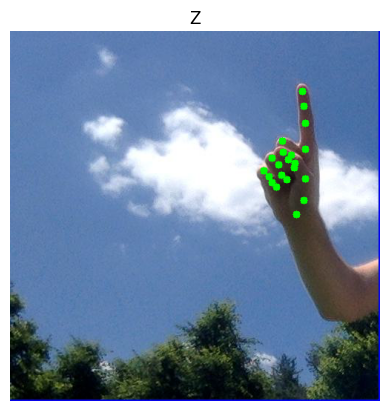

In [6]:
# Function to detect feature points and display them in the image
def detect_landmarks_draw_points(image_path):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Display of characteristic points
            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * image_rgb.shape[1]), int(landmark.y * image_rgb.shape[0])
                cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)
    
    landmarks_array = []
    for l in hand_landmarks.landmark:
        landmarks_array.append(l.x)
        landmarks_array.append(l.y)
        landmarks_array.append(l.z)
    landmarks_array = np.array(landmarks_array)

    plt.imshow(image_rgb)
    plt.title(rf.predict(landmarks_array.reshape(1, -1))[0])
    plt.show()
    return hand_landmarks.landmark

# Path to the image you wish to process
image_path = '/home/ant/projects/psl/dataset/images/Z10.jpg'

# Calling a function to detect feature points and display them on the image
landmarks = detect_landmarks_draw_points(image_path)

In [5]:
# Visualize the gesture recognition results
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    # Displays one image along with the predicted category name and score.
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(image, hand_landmarks, label):
    # Wyświetlanie punktów charakterystycznych
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks.landmark
    ])

    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        hand_landmarks_proto,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style()
    )

    plt.imshow(annotated_image)
    # Layout
    plt.title(label)
    plt.tight_layout()
    plt.show()

I0000 00:00:1704835050.377332   98810 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704835050.400134  100881 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA GeForce GTX 970/PCIe/SSE2


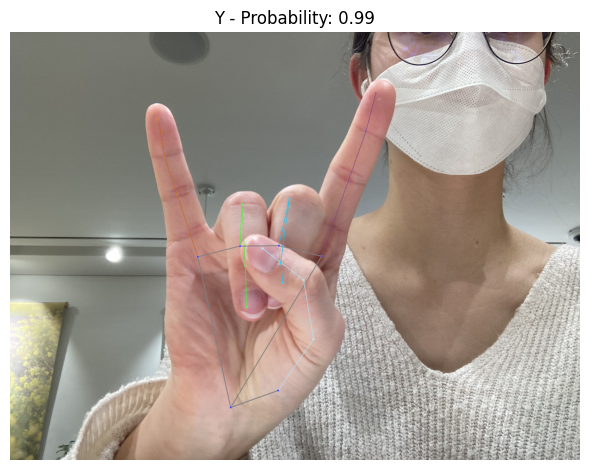

In [183]:
# Function to detect feature points and display them on the image with a connection
def detect_landmarks_draw_lines_points(image_path):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)
    # Classification
    landmarks_array = []
    for l in results.multi_hand_landmarks[0].landmark:
        landmarks_array.append(l.x)
        landmarks_array.append(l.y)
        landmarks_array.append(l.z)
    landmarks_array = np.array(landmarks_array)
    label = rf.predict(landmarks_array.reshape(1, -1))[0]
    probabilities = rf.predict_proba(landmarks_array.reshape(1, -1))[0]
    max_probability = np.max(probabilities)
    max_probability_index = np.argmax(probabilities)
    # print(probability)
    # print(type(label))

    display_batch_of_images_with_gestures_and_hand_landmarks(image_rgb, results.multi_hand_landmarks[0], f"{label} - Probability: {max_probability:.2f}")

# Path to the image you wish to process
image_path = '/home/ant/projects/psl/dataset/images/Y75.jpg'

# Calling a function to detect feature points and display them on the image
r = detect_landmarks_draw_lines_points(image_path)

In [14]:
rf.fit(X_train, y_train)

# Function to detect feature points and display them in the image
def detect_landmarks_final(image_path, selected_classes=None ):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        # Classification
        landmarks_array = []
        for l in results.multi_hand_landmarks[0].landmark:
            landmarks_array.append(l.x)
            landmarks_array.append(l.y)
            landmarks_array.append(l.z)
        landmarks_array = np.array(landmarks_array)

        # Predict label and get probabilities
        label = rf.predict(landmarks_array.reshape(1, -1))[0]
        probabilities = rf.predict_proba(landmarks_array.reshape(1, -1))[0]
        max_probability = np.max(probabilities)
        # max_probability_index = np.argmax(probabilities)
        # print(probability)
        # Print probabilities for each class
        for class_label, probability in zip(rf.classes_, probabilities):
            print(f"Probability for {class_label}: {probability:.2f}")

        # Display the image only for selected classes
        if selected_classes and label in selected_classes:
            # Simplified display function without hand landmarks
            plt.imshow(image_rgb)
            plt.title(f"{label} - Probability: {max_probability:.2f}")
            plt.show()
            # Return the predicted label for counting purposes
            return label
       
    else:
            print(f"No hands detected in {image_path}")
    # If no hands detected, return None
    return None

# # Path to the image you wish to process
# image_path = '/home/ant/projects/psl/dataset/images/Ć20.jpg'

# # Calling a function to detect feature points and display them on the image
# r = detect_landmarks_final(image_path)

Probability for A: 0.00
Probability for B: 0.00
Probability for C: 0.00
Probability for CH: 0.04
Probability for CZ: 0.02
Probability for Ć: 0.00
Probability for Ć-: 0.00
Probability for D: 0.00
Probability for E: 0.00
Probability for Ę: 0.01
Probability for F: 0.00
Probability for G: 0.00
Probability for H: 0.14
Probability for I: 0.00
Probability for J: 0.00
Probability for K: 0.01
Probability for L: 0.00
Probability for M: 0.00
Probability for N: 0.00
Probability for Ń: 0.00
Probability for O: 0.00
Probability for Ó: 0.02
Probability for P: 0.00
Probability for R: 0.01
Probability for RZ: 0.73
Probability for S: 0.00
Probability for SZ: 0.01
Probability for Ś: 0.00
Probability for T: 0.00
Probability for U: 0.00
Probability for W: 0.00
Probability for Y: 0.00
Probability for Z: 0.00
Probability for Ź: 0.00
Probability for Ż: 0.01
Probability for Ł: 0.00
No hands detected in /home/ant/projects/psl/dataset/images/N22.jpg
No hands detected in /home/ant/projects/psl/dataset/imag

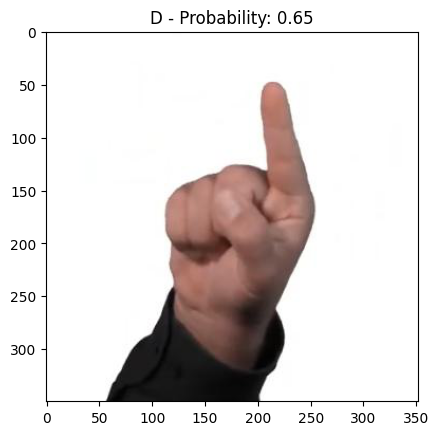

Probability for A: 0.00
Probability for B: 0.00
Probability for C: 0.00
Probability for CH: 0.00
Probability for CZ: 0.02
Probability for Ć: 0.00
Probability for Ć-: 0.00
Probability for D: 0.00
Probability for E: 0.00
Probability for Ę: 0.00
Probability for F: 0.59
Probability for G: 0.02
Probability for H: 0.00
Probability for I: 0.00
Probability for J: 0.00
Probability for K: 0.02
Probability for L: 0.00
Probability for M: 0.00
Probability for N: 0.00
Probability for Ń: 0.00
Probability for O: 0.04
Probability for Ó: 0.05
Probability for P: 0.00
Probability for R: 0.00
Probability for RZ: 0.00
Probability for S: 0.09
Probability for SZ: 0.01
Probability for Ś: 0.01
Probability for T: 0.12
Probability for U: 0.00
Probability for W: 0.03
Probability for Y: 0.00
Probability for Z: 0.00
Probability for Ź: 0.00
Probability for Ż: 0.00
Probability for Ł: 0.00
Probability for A: 0.00
Probability for B: 0.36
Probability for C: 0.05
Probability for CH: 0.00
Probability for CZ: 0.00
P

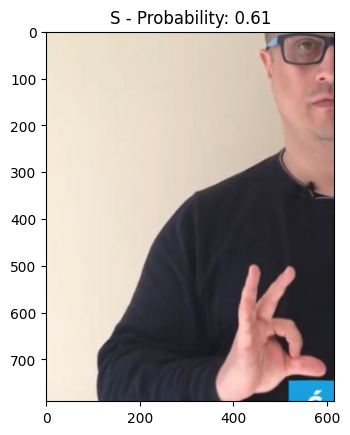

In [16]:
# Modify the function to accept selected_classes argument and count argument
def detect_landmarks_for_all_images(images_path, selected_classes=None, count_per_class=1):
    class_image_count = {}

    for filename in os.listdir(images_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(images_path, filename)
            label = detect_landmarks_final(image_path, selected_classes)

            if label:
                # Count the number of images displayed for each class
                class_image_count[label] = class_image_count.get(label, 0) + 1

                # Stop displaying images for a class after reaching the specified count
                if class_image_count.get(label, 0) >= count_per_class:
                    selected_classes.remove(label)

                # Stop processing images once one image per class has been displayed for all selected classes
                if not selected_classes:
                    break

# Path to the image you wish to process
images_path = '/home/ant/projects/psl/dataset/images/'


# Get 2 random classes from the RandomForestClassifier classes
random_classes = random.sample(rf.classes_.tolist(), 2)

# Convert random_classes to a set to use the discard method
random_classes_set = set(random_classes)

# Set the count of images to display per class
count_per_class = 1

# Calling a function to detect feature points and display one image per class for the selected classes
detect_landmarks_for_all_images(images_path, selected_classes=random_classes, count_per_class=count_per_class)